### Import all packages needed

In [1]:
#Import library
#Data preprocessing
import numpy as np #linear algebra
import pandas as pd #data processing, CSV files I/O (e.g pd.read_csv)
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re

# visualization
import matplotlib.pyplot as plt
from collections import Counter
# from worldcloud import WorldCloud

# Feature engineering
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Machine Learning Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Activation,Bidirectional
import tensorflow as tf

# Evaluation metrics
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
import seaborn as sns
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load and Explore the Data

- The dataset contains 83,448 entries with two columns: label and text.
- The label column indicates whether the email is spam (1) or not spam (0).
- The text column contains the email content.
- The dataset is balanced, with a roughly equal distribution of spam and non-spam emails

In [5]:
# Load the dataset
file_path = '../combined_spam_mail_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print('First 5 rows\n',data.head())
print('\nData Information\n',data.info())
print('\nData Description\n',data.describe())
print('\nMissing Values\n',data.isnull().sum())
print('\nShape of the data\n',data.shape)

First 5 rows
    label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB

Data Information
 None

Data Description
               label
count  83448.000000
mean       0.526196
std        0.499316
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000

Missing Values
 label    0
text     0
dtype: int64

Shape of the data
 (83448, 2)


### Data Preprocessing

##### Cleaned the text by removing punctuation and numbers, and converting to lowercase.

Often, characters, symbols, and numbers usually don't contribute to differentiating spam from legitimate emails

In [6]:
# Function to clean text
def clean_text(text):
    text = text.lower() #Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    
    return text

# clean the text data
data['cleaned_text'] = data['text'].apply(clean_text)

def remove_special_characters(word):
    return word.translate(str.maketrans('', '', string.punctuation))
data['text'] = data['text'].apply(remove_special_characters)

##### Remove English stop-words

Stopwords e like ‘the’, ‘a’,.... can be removed from the text because they don’t provide valuable information.

In [7]:
#Define stop-words in English
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def remove_stop_words(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

#Tokenize the text
data['text'] = data['text'].apply(word_tokenize)

#Remove stop words
data['text'] = data['text'].apply(remove_stop_words)

#Rejoin words for EDA
data['text'] = data['text'].apply(' '.join)

##### Removal of hyperlinks

Some emails contains URL which doesn't provide any valuable information.

In [8]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

data['text'] = data['text'].apply(remove_hyperlink)

### Exploratory Data Analysis


Let check with an example of a spam text

In [9]:
for i in range (1,3):
    print("Email #"+str(i))
    spam_email = data[data['label'] == 1]['text'].iloc[i]
    print(spam_email+"\n")

Email #1
wulvob get medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt ever stopped wonder much average man pays mediecines ap painkillers drugs improve quality life weight reducing tablets many escapenumber whats worse mediucine costs lot branded rfwur intrested http dmvrwm remunerativ net dfuaeirxygiq visit website escapenumber

Email #2
university degree obtain prosperous future money earning power prestige comes career position youve always dreamed diploma prestigious non accredited unversities based present knowledge professional experience qualify required tests classes books examinations con

Let check with an example of a non-spam text

In [10]:
for i in range (1,3):
    print("Email #"+str(i))
    non_spam_email = data[data['label'] == 0]['text'].iloc[i]
    print(non_spam_email+"\n")

Email #1
thanks answers guys know checked rsync manual would rather get escapenumber sure answer one current script bin bash rsync avt exclude alpha exclude arm exclude hppa exclude hurd exclude iaescapenumber exclude mescapenumberk exclude mips exclude mipsel exclude multi arch exclude powerpc exclude sescapenumber exclude sh exclude sparc exclude source ftp de debian org debian cd var www mirror debian cd know loads excludes include distros soon rsync manual del alias delete delete delete extraneous files dest dirs delete receiver deletes transfer default delete receiver deletes xfer delete receiver deletes transfer delete excluded also delete excluded files dest dirs delete would suggest use thanks john escapelong escapenumber escapenumber escapenumber olleg samoylov wrote jonathan escapelong wrote sorry banal question favourite keys escapenumber stage rsync rsync verbose recursive links hard links times filter r tmp delete delay updates source url destination log file olleg samoylo

**Spam email vs. Non spam email chart**

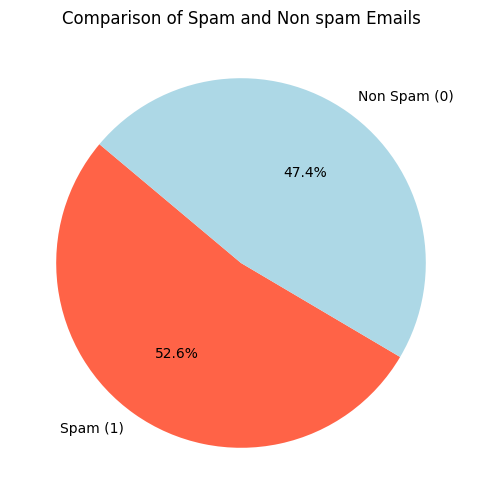

In [11]:
# Count the number of spam and legitimate emails
email_counts = data['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(email_counts, labels=['Spam (1)', 'Non Spam (0)'], autopct='%1.1f%%', startangle=140, colors=['tomato', 'lightblue'])
plt.title('Comparison of Spam and Non spam Emails')
plt.show()

The chart shows that 52.6% of the emails are classified as spam, while 47.4% are classified as non-spam. This nearly even split indicates that the dataset is fairly balanced between the two classes, which is good for training a machine learning model because it reduces the risk of the model being biased towards one class

**Word Frequency Analysis**

Create a bar chart of the most frequent words in both spam and legitimate emails

In [12]:
# Separate the spam and non spam emails
spam_emails = data[data['label'] == 1]['text']
non_spam_emails = data[data['label'] == 0]['text']

# Count word frequencies for spam
spam_words = Counter()
spam_emails.apply(lambda x: spam_words.update(x.split()))

# Count word frequencies for non spam emails
non_spam_words = Counter()
non_spam_emails.apply(lambda x: non_spam_words.update(x.split()))

# Get the most common words in spam and non spam emails
spam_common = spam_words.most_common(10)
non_spam_common = non_spam_words.most_common(10)

# Convert to DataFrame
spam_common_data = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
non_spam_common_data = pd.DataFrame(non_spam_common, columns=['Word', 'Frequency'])

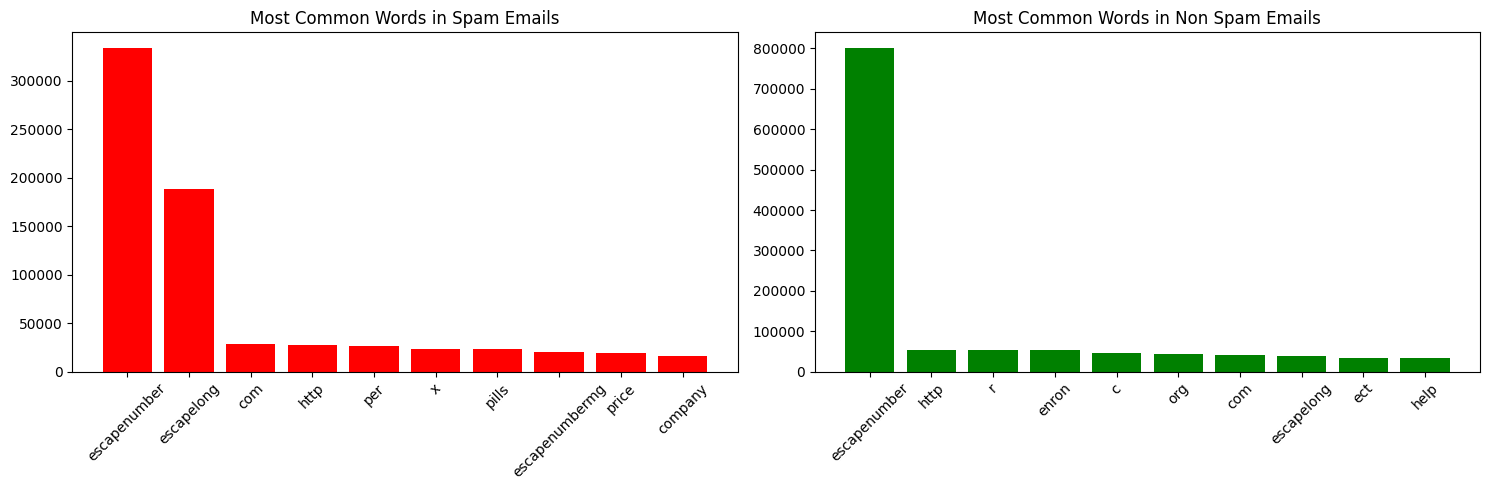

In [13]:
# Plotting the most common words in spam emails
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(spam_common_data['Word'], spam_common_data['Frequency'], color='red')
plt.title('Most Common Words in Spam Emails')
plt.xticks(rotation=45)

# Plotting the most common words in legitimate emails
plt.subplot(1, 2, 2)
plt.bar(non_spam_common_data['Word'], non_spam_common_data['Frequency'], color='green')
plt.title('Most Common Words in Non Spam Emails')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**N-gram Analysis**

The purpose of n-gram analysis is to explore the most common sequences of two or three words in spam and legitimate emails. This could help in understanding common phrases used in both types of emails.

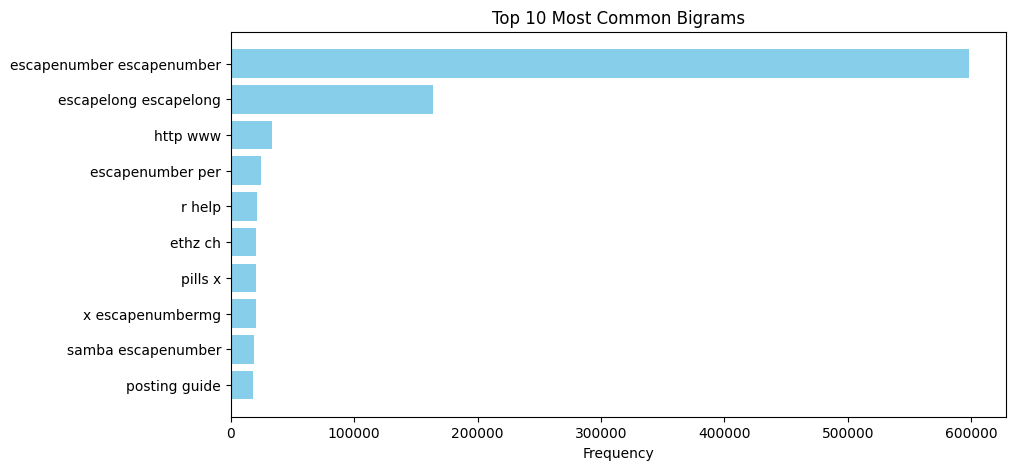

In [14]:
# Extract n-grams from text
def generate_ngrams(text, n=2):
    # Split the text into words
    words = text.split()
    # Ensure that there is no enough words
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

# Convert bigrams
data['bigrams'] = data['text'].apply(lambda x: generate_ngrams(x, n=2))

# count the frequencies
bigram_counts = Counter([bigram for sublist in data['bigrams'] for bigram in sublist])

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

### Feature Engineering

**Spliting data into train and test set**

In [15]:
# Split the data into features and target
X = data['text']  
y = data['label']  

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(58413,) (25035,) (58413,) (25035,)


**Tokenization**

Tokenization is the process of splitting text into smaller chunks, called tokens. Each token is an input to the machine learning algorithm as a feature. 

In Python, keras.preprocessing.text.Tokenizer is a utility function that help tokenizes a text into tokens while keeping only the words that frequently occur. After tokenizing the text, we often end up with a massive dictionary of words which won’t all be necessary. One solution for this problem is setting ‘max_features’ to select the top frequent words that we want to consider.

In [16]:
# Tokenize the text data
max_features = 5000 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print(X_train_seq, X_test_seq)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**Padding**

Padding is the step of making all tokens for all emails to equal size. Since we send input in batches of data points, information might be lost when inputs are of different sizes. So, making them the same size help eases batch updates.

In [17]:
#Average Length
average_length = data['text'].apply(len).mean()
print("Average Length: "+str(average_length))

max_length = 500 #Set to average length

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

Average Length: 1305.4409692263446


**Label the encoding target variable**

The model expect the target variable as a number instead of string. Therefore, we can use a Label encoder to convert our target variable.

In [18]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### Model Selection

To simplify with an example, let say we analyze a movie, which consists of a sequence of scenes. When we watch a scene, we can't understand the movie at whole, but rather in connection with previous scenes. Text works in a similar way, a machine learning model has to understand the text by utilizing already-learned text (like a human neural network).

For those reasons, Recurrent neural network (RNN) is a perfect fit. It has a repeating module that takes input from the previous stage and gives its output as input to the next stage. One limit of RNNs is that we can only retain information from the most recent stage. To learn long-term dependencies, our network needs memorization power. Therfore, Long Short Term Memory Networks (LSTMs) works perfectly to solve this problem.

In short, LSTMs are a special case of RNNs, which have similar chain-like structure as RNNs, but with a different repeating module structure. In this model, we will use Bi-directional LSTM.  In a Bi-directional LSTM, the input sequence is fed in two ways: one from past to future and one from future to past. This can provide additional context to the network and result in a fuller understanding of the data.

In [19]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


**Train the model**

In [20]:
history = model.fit(X_train_padded, y_train_encoded, 
                    batch_size=512, 
                    epochs=20, 
                    validation_data=(X_test_padded, y_test_encoded))

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1708s 14s/step - accuracy: 0.7575 - loss: 0.4536 - val_accuracy: 0.9660 - val_loss: 0.1066
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1204s 10s/step - accuracy: 0.9769 - loss: 0.0764 - val_accuracy: 0.9786 - val_loss: 0.0698
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1165s 10s/step - accuracy: 0.9855 - loss: 0.0501 - val_accuracy: 0.9765 - val_loss: 0.0723
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1186s 10s/step - accuracy: 0.9867 - loss: 0.0464 - val_accuracy: 0.9807 - val_loss: 0.0638
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1250s 11s/step - accuracy: 0.9900 - loss: 0.0364 - val_accuracy: 0.9828 - val_loss: 0.0592
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1254s 11s/step - accuracy: 0.9927 - loss: 0.0282 - val_accuracy: 0.9836 - val_loss: 0.0560
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1296s 11s/step - accuracy: 0.9913 - loss: 0.0319 - val_accuracy: 0.9821 - val_loss: 0.0617
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1311s 11s/step - accuracy: 0.9937 - loss: 0

### Performance Metrics

**Prediction and Evaluation**

In [21]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]


783/783 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step


In [23]:
# Evaluate the model
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))


Precision: 98.42%
Recall: 98.48%
F1 Score: 98.45%


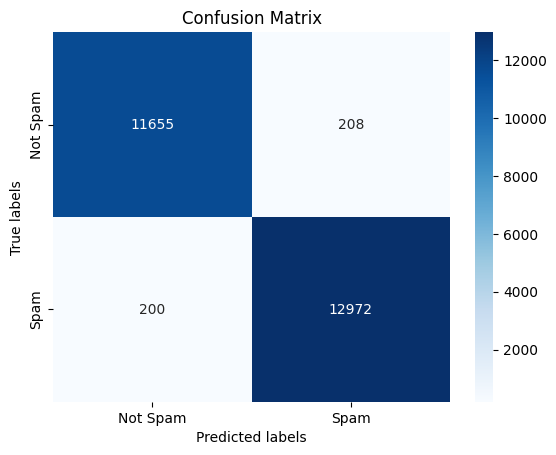

In [24]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

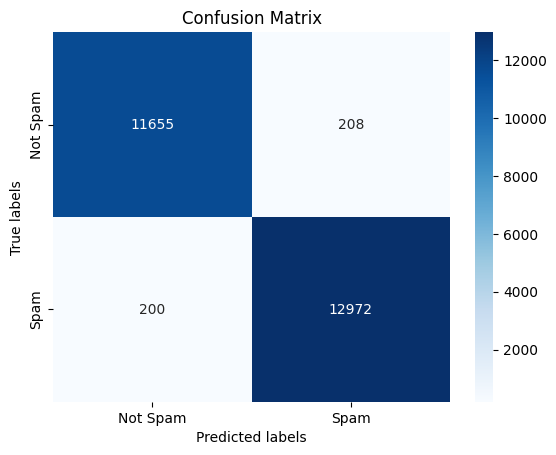

In [25]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [26]:
import pickle

In [30]:
# Save the model in the native Keras format
model.save('spam_detector_model.keras')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)